## Imports

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import seaborn as sns
pd.options.display.max_columns = 5000
from original_preprocessing import *

Populating the interactive namespace from numpy and matplotlib


## Preprocessing

Feature Engineering Todo:
- Are there any repeat violators?
- Violation descriptions -- are these valuable?
- Is the fee amount predictive or not?
    - It occurs to me that the answer is "Probably".

In [2]:
%%time
# Open data files
path = "./data/"

train = pd.read_csv(path+'train.csv', encoding='iso-8859-1')[::]
test = pd.read_csv(path+'test.csv')
test_ticket_id = np.array(test['ticket_id'])

train, test, features, target = preprocessing(train, test)

<string>:2: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.


Converting datetime to years/months/days... ticket_issued_date
Converting datetime to years/months/days... hearing_date
Converting to categorical... agency_name # variables: 5
Converting to categorical... violation_code # variables: 72
Converting to categorical... disposition # variables: 8
Converting to categorical... grafitti_status # variables: 2
Number of features: 100
CPU times: user 4.64 s, sys: 1.55 s, total: 6.2 s
Wall time: 6.38 s


In [3]:
# TODO: Add this as a feature.
# from censusgeocode import CensusGeocode
# cg = CensusGeocode()

# def return_geoid(lon, lat):
#     # geoid = cg.address(address, city='Detroit', state='MI')
#     geoid = cg.coordinates(x=lon, y=lat)
#     try:
#        print(geoid[0]['Census Tracts'][0][u'GEOID'])
#     except:
#        print(lon, lat, geoid)
#     return geoid #int(geoid)

In [4]:
# Train Set
X = train[features]
y = np.array(train[target]).ravel()

# Normalize
mn = X.mean()
std = X.std()
X = (X - mn)/std

X = X.replace([np.inf, -np.inf], np.nan)
X[pd.isnull(X)] = 0

# Submissions Set
Xtest = (test[features] - mn) / std
Xtest = Xtest.replace([np.inf, -np.inf], np.nan)
Xtest[pd.isnull(Xtest)] = 0

## Evaluation

### Define Models

In [5]:
# Imports
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble     import RandomForestClassifier
from sklearn.ensemble     import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Add classifiers
classifiers = {
    "GradBoost_C": GradientBoostingClassifier(learning_rate=0.05,
                                        max_features='auto',
                                        max_depth=2,
                                        min_samples_leaf=3,
                                        min_samples_split=4),
    'MLP_C_100x2': MLPClassifier(hidden_layer_sizes=(25, 25, 25), learning_rate='adaptive'),
    "RF_R": RandomForestRegressor(n_estimators=25)
}

# Create Train/Test split for evaluation.
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

### Evaluate with K-Fold Cross Validation

In [6]:
# Imports / helper functions
from sklearn.metrics import roc_auc_score

def roc_auc_scorer(y_true, y_pred):
    return roc_auc_score(y_true, y_pred[:, 1])

def accuracy_with_rescaling(y, y_pred):
    """Potentially depricated now that we understand that we shouldn't be rounding output"""
    y_pred = np.round((y_pred - y_pred.min()) / y_pred.max())
    return sum(y_pred == y) / len(y)

In [7]:
%%time

scores = dict()
# Select the model
for classifier_type in classifiers.keys():
    # Train classifier
    clf = classifiers[classifier_type]
    # Score classifier
    # If using cross_val_score, there is no need for train test split.
    try:
        # For the classifiers -- needs_proba=True and alternative scorer for classifiers
        model_score = cross_val_score(clf, X, y, cv=5, n_jobs=-1, scoring=make_scorer(roc_auc_scorer, needs_proba=True))
    except AttributeError:
        # For the regressors
        model_score = cross_val_score(clf, X, y, cv=5, n_jobs=-1, scoring=make_scorer(roc_auc_score))
    # Record score
    scores[classifier_type] = model_score
    display(pd.DataFrame({classifier_type: scores[classifier_type]}))

scores = pd.DataFrame(data=scores)
display(scores.describe())

,GradBoost_C
0,0.802470
1,0.789526
2,0.841539
3,0.785075
4,0.767408


,RF_R
0,0.708721
1,0.780987
2,0.778757
3,0.705860
4,0.735640


,MLP_C_100x2
0,0.685305
1,0.618589
2,0.775596
3,0.705699
4,0.713527


,GradBoost_C,MLP_C_100x2,RF_R
count,5.000000,5.000000,5.000000
mean,0.797204,0.699743,0.741993
std,0.027781,0.056510,0.036486
min,0.767408,0.618589,0.705860
25%,0.785075,0.685305,0.708721
50%,0.789526,0.705699,0.735640
75%,0.802470,0.713527,0.778757
max,0.841539,0.775596,0.780987


CPU times: user 5.58 s, sys: 869 ms, total: 6.44 s
Wall time: 4min 3s


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

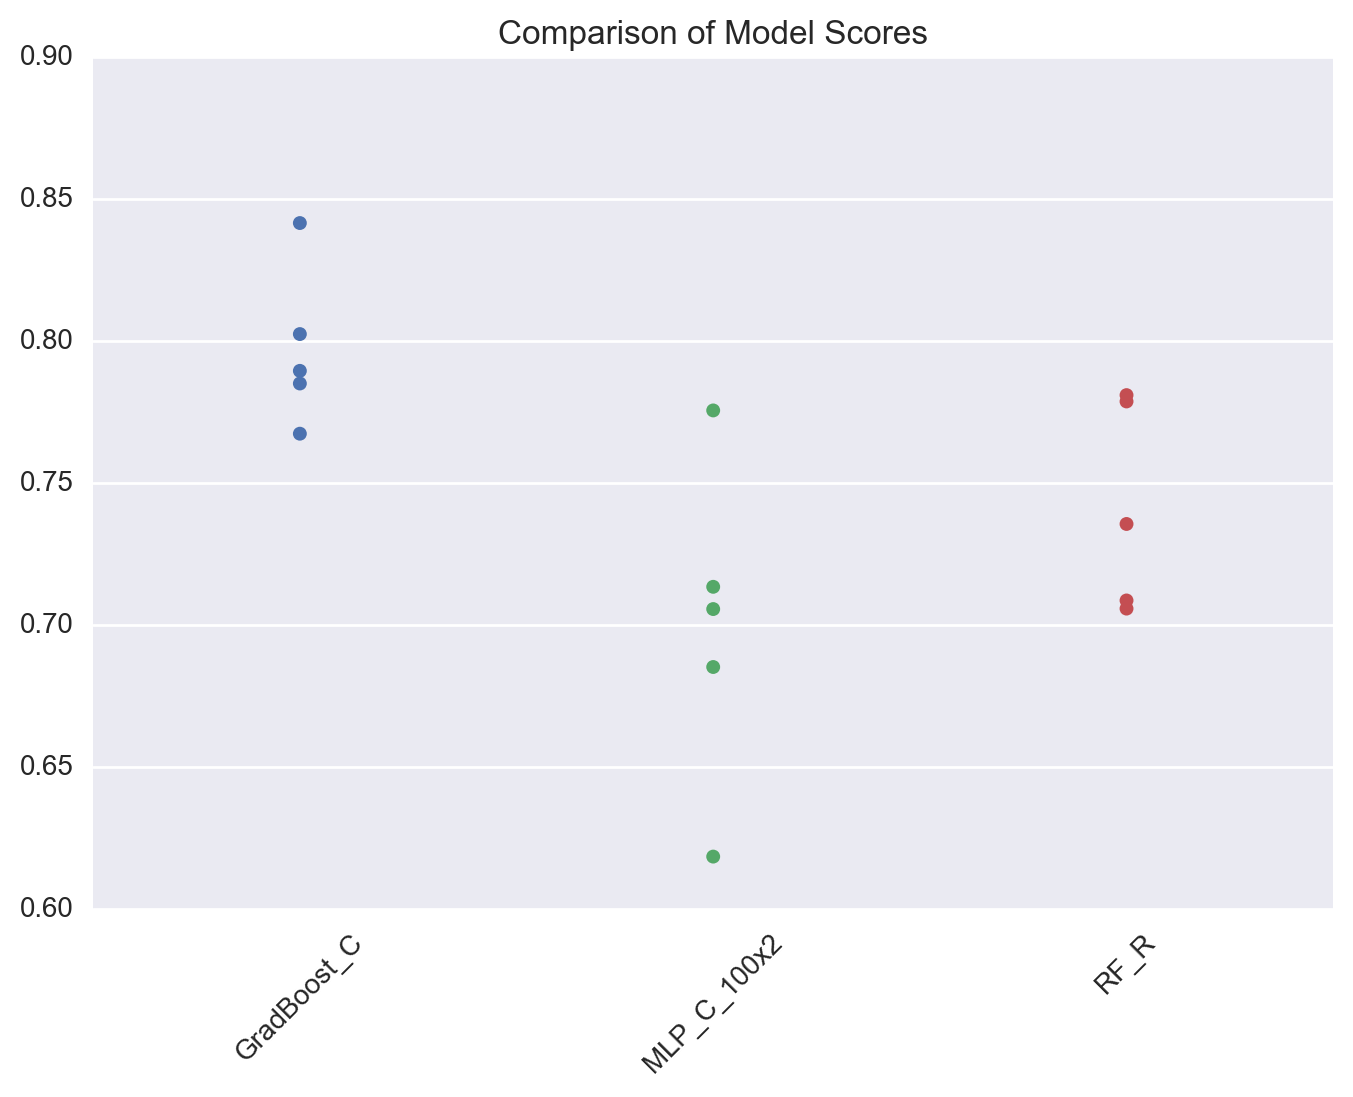

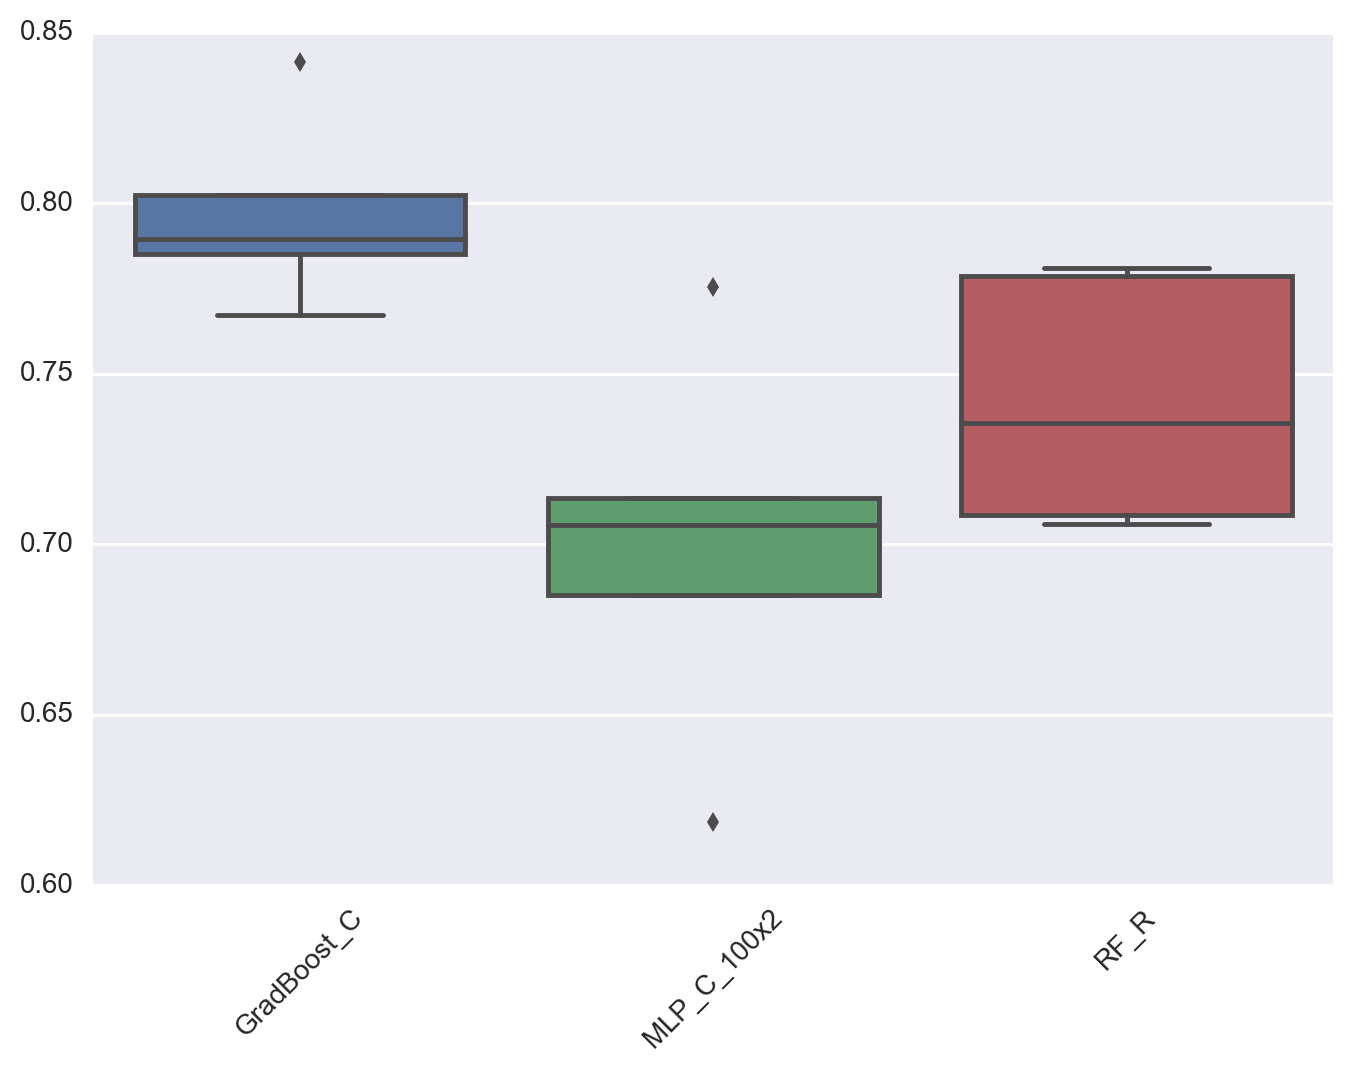

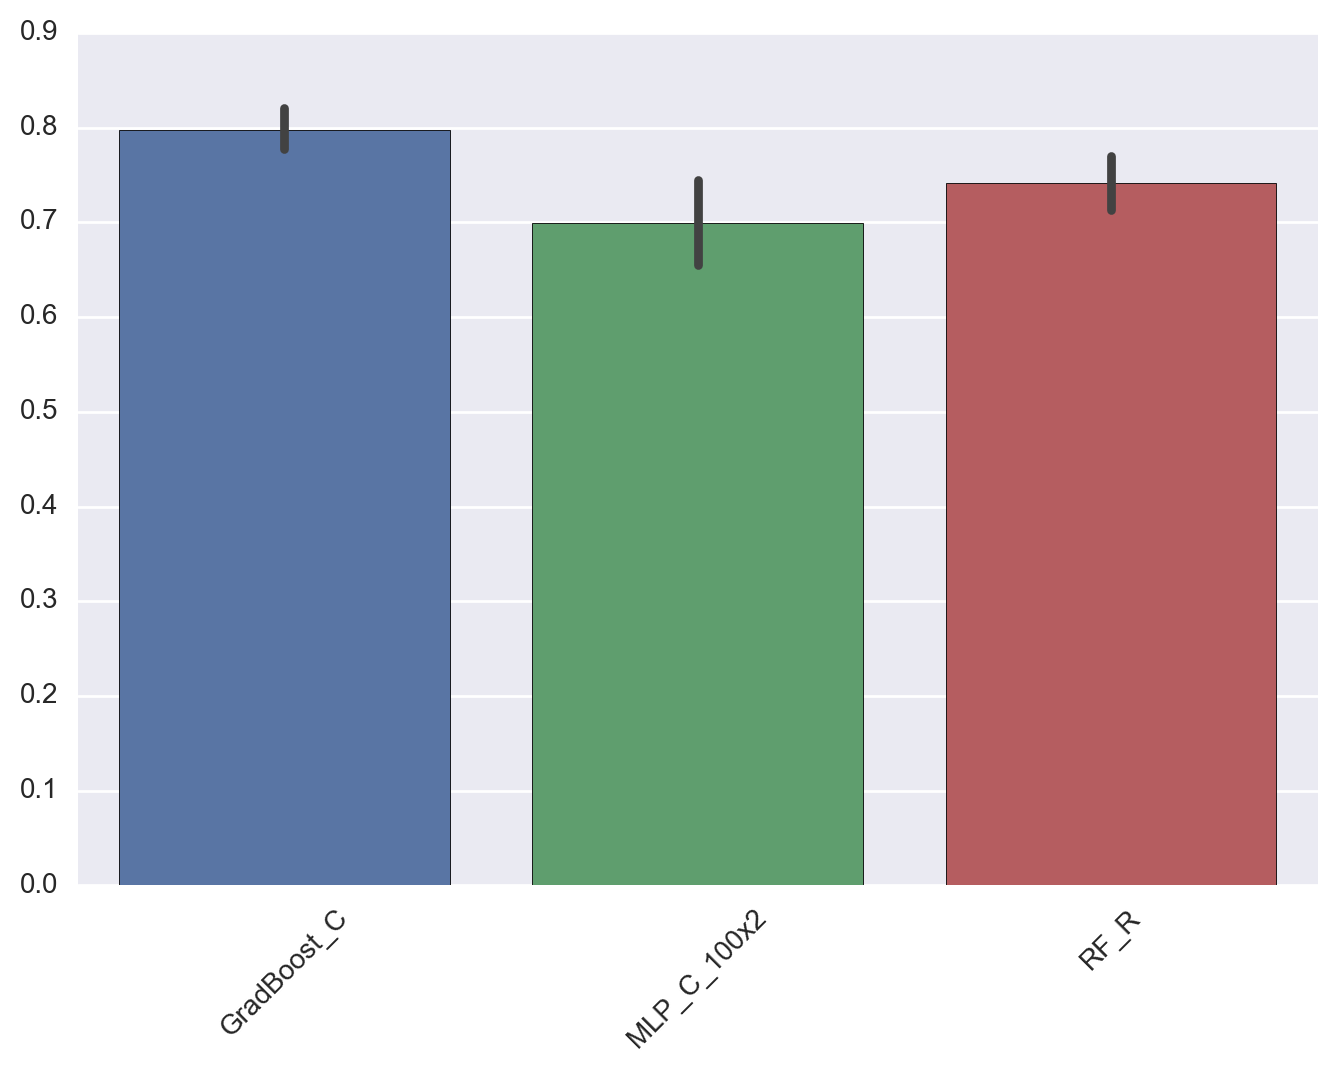

In [8]:
plt.figure()
sns.stripplot(data=scores)
plt.xticks(rotation=45)
plt.title('Comparison of Model Scores')

plt.figure()
sns.boxplot(data=scores)
plt.xticks(rotation=45)
plt.figure()
sns.barplot(data=scores)
plt.xticks(rotation=45)

In [9]:
%%time
## Submission
def make_submission(model_name, clf):
    print('Fitting %s ...' % model_name)
    # Train classifier
    clf.fit(X, y)

    # Predict
    print('Generating Predictions ...')
    try:
        # For classifiers, we want the predicted probabilities (for label=True)
        y_pred = clf.predict_proba(Xtest)[:, 1]
    except AttributeError:
        # If regressor, get the scaled predictions
        y_pred = np.array(clf.predict(Xtest))
        # If output is not in range [0..1], this converts to [0..1]
        y_pred = y_pred - y_pred.min()
        y_pred = y_pred / y_pred.max()



    # Save to CSV
    print('Saving to CSV ...')
    df = {"ticket_id":test_ticket_id, "compliance":y_pred}
    df = pd.DataFrame(df, columns=["ticket_id", "compliance"])
    df.to_csv("./data/submission_%s.csv" % model_name, index=False)
    print('finished!')
    print('---------------------')

def make_all_submissions(classifiers):
    """classifiers: A dictionary of classifier name keys and sklearn classifier value pairs"""
    for model_name, clf in classifiers.items():
        make_submission(model_name, clf)

# Make all submissions
make_all_submissions(classifiers)

# Make individual submission
# target_clf = "MLP_C_D"
# make_submission(target_clf, classifiers[target_clf])

Fitting GradBoost_C ...
Generating Predictions ...
Saving to CSV ...
finished!
---------------------
Fitting RF_R ...
Generating Predictions ...
Saving to CSV ...
finished!
---------------------
Fitting MLP_C_100x2 ...
Generating Predictions ...
Saving to CSV ...
finished!
---------------------
CPU times: user 2min 3s, sys: 11.9 s, total: 2min 15s
Wall time: 1min 38s
